# Plotting Ballistic Ejecta from the South Pole-Aitken Impact

## Workflow:
This script runs through all the tracers in the data file and selects the tracers that follow a ballistic trajectory. Using 3D equations for ballistic motion, we plot the 

In [1]:
#import python packages 
import cartopy
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
trm_dict = {1 : "Moon Crust", 2 : "Moon Mantle", 3 : "Impactor Mantle", 4 : "Impactor Core"}

In [3]:
#import the data file. Change the path to your file :) 
data = tools.load_ballistic_data("/Users/namya/Desktop/tracer_export_all.npz", end = 400)
# print(data['ymark'].max())

In [4]:
#get data
velocity_data = tools.get_velocity(data)
radial_distance_data = tools.get_radial_distance(data)
radial_velocity_data = tools.get_radial_velocity(data)
radial_acceleration_data = tools.get_radial_acceleration(data, radial_velocity_data)
average_time = tools.get_average_time(data)

In [5]:
h_launch = 150
tracer_idxs, time_steps = tools.BallisticCheckVec(data, h_launch)
# print(np.min(time_steps))
# print(np.max(time_steps))
# print(time_steps.shape)
ejection_times = data['time'][time_steps]

In [6]:
tracer_material = data['trm'][tracer_idxs]

In [7]:
R0 = 1750
g0 = 0.00162

g = g0 * R0**2 / (R0 + h_launch) **2
v_tilda = tools.get_v_tilda_vec(velocity_data, tracer_idxs, time_steps, R0 + h_launch, g)

In [8]:
v_r, longitude, latitude = tools.get_launch_vector_vec(data,velocity_data, tracer_idxs, time_steps)
longitude_magnitude, longitude_direction = longitude
latitude_magnitude, latitude_direction = latitude

In [9]:
theta_launch, height, distance, azimuth = tools.get_ballistic_vectors_vec(data, velocity_data, tracer_idxs, time_steps, h_launch, R0, g0)

/Users/namya/year4_project/tools/ballistics.py:105: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(data['zmark'] / (data['r']+ 1e-12))[:, :-1]  # angle at the centre of the moon


In [10]:
print(azimuth.min())
print(azimuth.max())
print(azimuth.mean())

0.0
181.78924737244927
141.61017248650668


In [43]:
final_latitude, final_longitude = tools.track_vec(latitude[0], longitude[0], -1 * azimuth, distance)

In [44]:
def make_dataframe(tracer_idxs, ejection_times, v_r, longitude, latitude, theta_launch, height, distance, final_longitude, final_latitude, tracer_material, azimuth):
    initial_df = pd.DataFrame({'Tracer Index' : tracer_idxs, 'Ejection Time' : ejection_times, 'Resultant Velocity' : v_r, 'Launch Longitude' : longitude[0], 'Launch Latitude' : latitude[0], 'Launch Angle' : theta_launch, 'Height' : height, 'Distance' : distance, 'Landing Longitude' : final_longitude, 'Landing Latitude' : final_latitude, 'Tracer Material' : tracer_material, 'Azimuth' : azimuth})
    return initial_df

In [45]:
df = make_dataframe(tracer_idxs, ejection_times, v_r, longitude, latitude, theta_launch, height, distance, final_longitude, final_latitude, tracer_material, azimuth)
df
# print(df['Launch Longitude'][df['Launch Longitude'] < 150])
# print(df['Ejection Time'][df['Ejection Time'] > 0].min())
# print(df.Distance)
# print(df.Distance.describe())
# print(df[df.Distance < 0])
# # print(df['Ejection Time'].describe())
# print(df.loc[1360])
# print(df['Resultant Velocity'].describe())
# # print(df['Tracer Material'].value_counts())
# print(df['Resultant Velocity'].describe())

,Tracer Index,Ejection Time,Resultant Velocity,Launch Longitude,Launch Latitude,Launch Angle,Height,Distance,Landing Longitude,Landing Latitude,Tracer Material,Azimuth
0,0,112.025597,3.567570,178.928060,68.623144,53.780778,-4165.526625,3747.565530,176.398754,-54.059631,4.0,178.236196
1,1,110.039398,3.675897,178.956358,68.769574,52.755341,-4083.874445,3690.357295,176.576237,-52.041548,4.0,178.295441
2,2,210.030502,1.564486,178.973916,63.860490,43.234086,1115.458044,2748.912389,178.320432,-26.138652,4.0,179.413350
3,4,146.047302,3.035805,178.783652,66.573687,54.054510,-5243.161668,3877.581422,178.783652,-60.380056,4.0,180.000000
4,5,136.046997,2.775873,178.908277,67.246903,52.478551,-6752.403061,3906.837386,176.511662,-60.652654,4.0,178.511486
...,...,...,...,...,...,...,...,...,...,...,...,...
67953,524251,404.081696,0.828934,170.547593,58.113793,40.613468,132.819803,750.660985,166.103106,33.719464,2.0,171.084701
67954,524252,700.052612,0.408345,161.875505,54.655800,7.879490,1.217090,1118.995015,144.350702,20.507410,2.0,151.794733
67955,524280,296.067291,1.329092,175.046999,60.703975,52.199425,705.097133,1644.611834,170.230194,6.980468,2.0,174.075017
67956,524281,374.084106,0.938261,169.255493,59.026070,44.094048,205.951240,914.207949,161.238375,29.600587,2.0,165.934169


In [1]:
#exclude tracers where their velocity exceeds the escape velocity of the moon
df = df[df['Resultant Velocity']< 2.38] 
df

NameError: name 'df' is not defined

In [47]:
c1 = df['Launch Longitude'] > 120.0
tx = df[c1]
c2 = tx['Launch Longitude'] < 140.0
tx = tx[c2]
c3 = tx["Launch Latitude"] > 60.0
tx = tx[c3]
c4 = tx["Launch Latitude"] < 80
tx = tx[c4]
tx

,Tracer Index,Ejection Time,Resultant Velocity,Launch Longitude,Launch Latitude,Launch Angle,Height,Distance,Landing Longitude,Landing Latitude,Tracer Material,Azimuth
321,524674,584.017883,0.449862,138.707091,62.196718,27.277583,16.612825,418.616490,117.626776,54.030463,2.0,116.921407
373,524734,584.017883,0.449862,138.707091,62.196718,27.277583,16.612825,418.616490,117.626776,54.030463,2.0,116.921407
374,524735,498.082794,0.544550,130.756669,65.909152,31.781393,33.145060,452.256075,103.223552,58.263283,2.0,107.927005
375,524736,570.026306,0.455400,124.600941,66.628269,27.937344,17.816148,415.949023,95.805482,61.200770,2.0,99.757407
384,524764,584.017883,0.449862,138.707091,62.196718,27.277583,16.612825,418.616490,117.626776,54.030463,2.0,116.921407
...,...,...,...,...,...,...,...,...,...,...,...,...
66958,521188,542.017883,0.465489,137.602554,62.568240,36.061685,29.315859,364.509020,119.020423,55.336649,2.0,118.781941
66969,521217,546.082214,0.462991,138.111934,62.361725,31.419658,22.803413,393.040280,118.827550,54.284223,2.0,120.041600
66980,521246,542.017883,0.484349,138.693778,62.257619,36.033417,31.888814,378.570696,119.800228,54.651974,2.0,119.215536
66991,521275,538.077209,0.467383,139.265042,62.159076,36.954767,30.823649,360.581649,120.455155,55.383675,2.0,116.456844


In [48]:
# xxx = np.array(tx[tx['Landing Longitude'] > 241])[0]
# # print(azimuth_filtered)
# # print(azimuth_filtered.min())
# # print(azimuth_filtered.max())
# # print(azimuth_filtered.mean())
# # xxx = np.array(tx[tx['Tracer Index'] == 524674])[0]
# # print(xxx[7])
# tx[tx['Tracer Index'] == 9262]
# # print(xxx)
# print(tools.track(xxx[4], xxx[3], xxx[-1], 100))
print('minimum distance=' , distance.min())
print('maximum distance=' ,distance.max())
print('mean distance',distance.mean())
print('median distance',np.median(distance))

minimum distance= 1.3201420921788092
maximum distance= 224179.57727207337
mean distance 1888.60005498264
median distance 1486.0639925640626


In [49]:
df.to_csv("full_tracer.csv", index=False)    

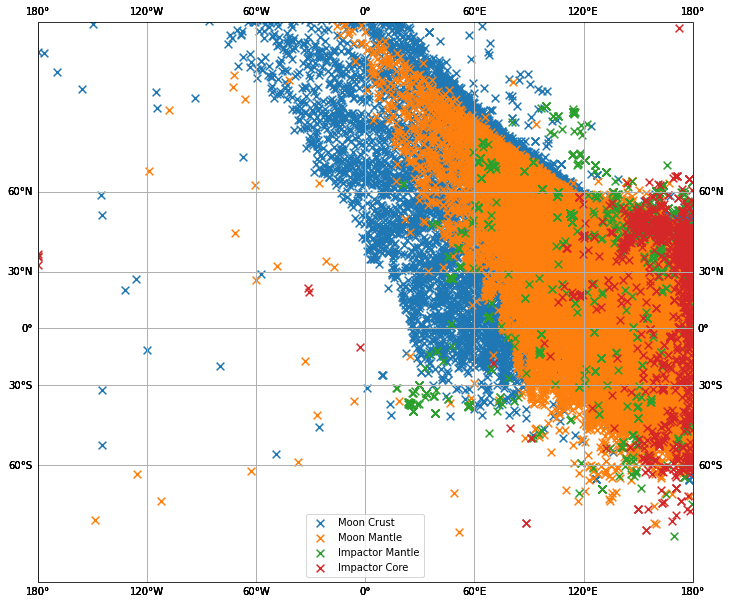

In [57]:
#plotting the tracers on a map in cartopy 

df_final = pd.read_csv('full_tracer.csv')


def main():
    fig = plt.figure(figsize=[10, 10])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-180,180 , 0, 90], ccrs.PlateCarree())
    ax1.set_global()
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    
    launch_longs = np.array(df_final['Launch Longitude'])
    launch_lats = np.array(df_final['Launch Latitude'])
    land_longs = np.array(df_final['Landing Longitude'])
    land_lats = np.array(df_final['Landing Latitude'])
    trm = np.array(df_final['Tracer Material']).astype(np.int64)
    
    for key in trm_dict:
        condition = np.where(trm == key)
#         ax1.scatter(launch_longs[condition], launch_lats[condition], marker= 'x', s = 60, label = trm_dict[key],  transform = ccrs.PlateCarree())
        ax1.scatter(land_longs[condition], land_lats[condition], marker = 'x', s = 60, label = trm_dict[key], transform =  ccrs.PlateCarree())
        ax1.gridlines(draw_labels = True)
    

    plt.legend()
    plt.savefig('Figures/material_map.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


if __name__ == '__main__':
    main()

In [51]:
def velo_range(min_v=0, max_v=2000):
    norm = mcolors.Normalize(vmin=min_v, vmax=max_v)
    m = cm.ScalarMappable(norm=norm, cmap='viridis')
    return (norm, m)

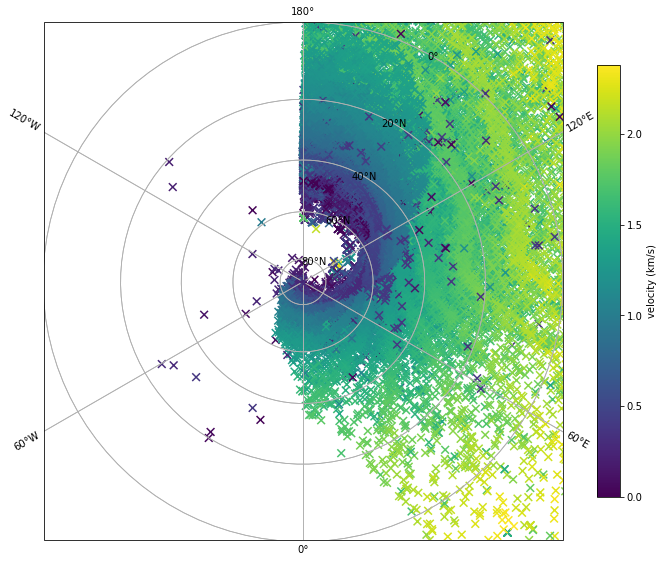

In [52]:
#plotting the tracers on a map in cartopy 

df_final = pd.read_csv('full_tracer.csv')
# print(np.max(v_r))


def main():
    fig = plt.figure(figsize=[16, 20])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo())

    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    
    launch_longs = np.array(df_final['Launch Longitude'])
    launch_lats = np.array(df_final['Launch Latitude'])
    land_longs = np.array(df_final['Landing Longitude'])
    land_lats = np.array(df_final['Landing Latitude'])
    v_r = np.array(df_final['Resultant Velocity'])
    
    # ax1.scatter(launch_longs[condition], launch_lats[condition], marker= 'x', s = 60, c = trm,  transform = ccrs.PlateCarree())
#     plot = ax1.scatter(land_longs, land_lats, marker = 'x', s = 60, c=v_r, cmap='viridis', transform =  ccrs.PlateCarree(), vmin = 0, vmax= 2.38)
    plot = ax1.scatter(land_longs, land_lats, marker = 'x', s = 60, c=v_r, cmap='viridis', transform =  ccrs.PlateCarree(), vmin = 0, vmax= 2.38)
    ax1.gridlines(draw_labels = True)
    
    # colorbar 
#     norm, m = velo_range(min_v = 0, max_v = 2.38)
    
    cbar = plt.colorbar(plot, label='velocity (km/s)', aspect=5, cax = fig.add_axes([0.52, 0.35, 0.02, 0.3]))
    
    plt.savefig('Figures/velocity_map.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


if __name__ == '__main__':
    main()

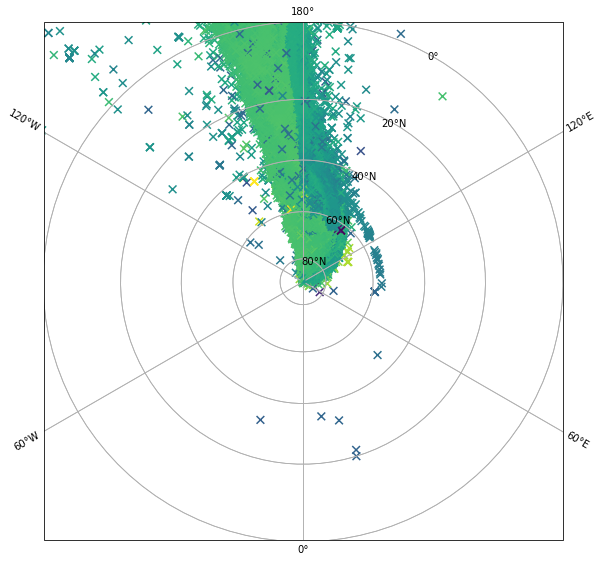

In [21]:
#plotting the tracers on a map in cartopy 

df_final = pd.read_csv('full_tracer.csv')


def main():
    fig = plt.figure(figsize=[16, 20])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo())

    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    
    launch_longs = np.array(df_final['Launch Longitude'])
    launch_lats = np.array(df_final['Launch Latitude'])
    land_longs = np.array(df_final['Landing Longitude'])
    land_lats = np.array(df_final['Landing Latitude'])
    theta_launch = np.array(df_final['Launch Angle'])
    
    # ax1.scatter(launch_longs[condition], launch_lats[condition], marker= 'x', s = 60, c = trm,  transform = ccrs.PlateCarree())
    ax1.scatter(land_longs, land_lats, marker = 'x', s = 60, c=theta_launch, cmap='viridis', transform =  ccrs.PlateCarree())
    ax1.gridlines(draw_labels = True)
    
    plt.savefig('Figures/theta_map.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


if __name__ == '__main__':
    main()

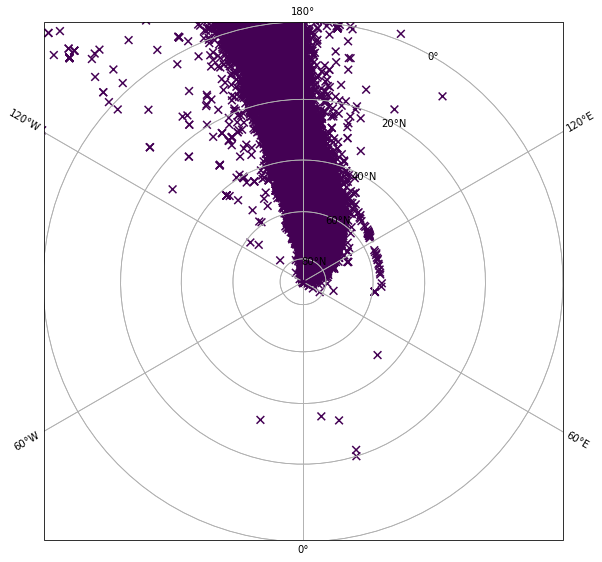

In [22]:
#plotting the tracers on a map in cartopy 

df_final = pd.read_csv('full_tracer.csv')


def main():
    fig = plt.figure(figsize=[16, 20])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo())

    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-180, 180, 0, 90], ccrs.PlateCarree())
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    tracer_idxs = np.array(df_final['Tracer Index'])
    r0 = data['r'][tracer_idxs, 0]
    depth = 1750 - r0
    
    launch_longs = np.array(df_final['Launch Longitude'])
    launch_lats = np.array(df_final['Launch Latitude'])
    land_longs = np.array(df_final['Landing Longitude'])
    land_lats = np.array(df_final['Landing Latitude'])
    
    # ax1.scatter(launch_longs[condition], launch_lats[condition], marker= 'x', s = 60, c = trm,  transform = ccrs.PlateCarree())
    ax1.scatter(land_longs, land_lats, marker = 'x', s = 60, c=depth, cmap='viridis', transform =  ccrs.PlateCarree())
    ax1.gridlines(draw_labels = True)
    
    plt.savefig('Figures/depth_map.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


if __name__ == '__main__':
    main()

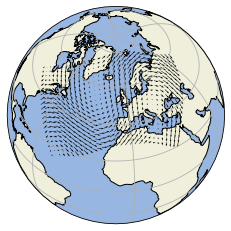

NameError: name 'ax' is not defined

In [23]:


def sample_data(shape=(20, 30)):
    """
    Return ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a rotated
    pole CRS, meaning that the vectors will be unevenly spaced in
    regular PlateCarree space.

    """
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

    x = np.linspace(311.9, 391.1, shape[1])
    y = np.linspace(-23.6, 24.8, shape[0])

    x2d, y2d = np.meshgrid(x, y)
    u = 10 * (2 * np.cos(2 * np.deg2rad(x2d) + 3 * np.deg2rad(y2d + 30)) ** 2)
    v = 20 * np.cos(6 * np.deg2rad(x2d))

    return x, y, u, v, crs


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-10, 45))


    

def sample_data(shape=(20, 30)):
    """
    Return ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a rotated
    pole CRS, meaning that the vectors will be unevenly spaced in
    regular PlateCarree space.

    """
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

    x = np.linspace(311.9, 391.1, shape[1])
    y = np.linspace(-23.6, 24.8, shape[0])

    x2d, y2d = np.meshgrid(x, y)
    u = 10 * (2 * np.cos(2 * np.deg2rad(x2d) + 3 * np.deg2rad(y2d + 30)) ** 2)
    v = 20 * np.cos(6 * np.deg2rad(x2d))

    return x, y, u, v, crs


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-10, 45))

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

    ax.set_global()
    ax.gridlines()

    x, y, u, v, vector_crs = sample_data()
    ax.quiver(x, y, u, v, transform=vector_crs)

    plt.show()


if __name__ == '__main__':
    main()
    ax.gridlines()

    x, y, u, v, vector_crs = sample_data()
    ax.quiver(x, y, u, v, transform=vector_crs)

    plt.show()


if __name__ == '__main__':
    main()